In [1]:
# installs transformers + torch
!pip install -q transformers[torch]


In [2]:
from transformers import pipeline
import pandas as pd, json


In [3]:
# BIO/MEDICAL NER model (public)

bio_ner = pipeline("ner",
                   model="d4data/biomedical-ner-all",
                   aggregation_strategy="simple", device=-1)  # -1 = CPU, change to 0 if GPU

# General-domain NER model (CoNLL style)
general_ner = pipeline("ner",
                       model="dslim/bert-base-NER",
                       aggregation_strategy="simple", device=-1)
print("Pipelines ready")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/266M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cpu


config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


Pipelines ready


In [4]:
#Example Clinical texts

texts = [
  "The patient was diagnosed with Type 2 diabetes and prescribed metformin 500 mg daily.",
  "Patient presents with chest pain and was started on aspirin and nitroglycerin.",
  "Diagnosis: glioblastoma multiforme. Treatment: temozolomide chemotherapy."
]


In [5]:
#Run both models and collect the results

def run_models(text):
    out_bio = bio_ner(text)
    out_gen = general_ner(text)
    return out_bio, out_gen

results = []
for t in texts:
    bio_out, gen_out = run_models(t)
    results.append({"text": t, "biobert": bio_out, "general": gen_out})

# Show results neatly
for r in results:
    print("TEXT:", r["text"])
    print("Bio (medical) NER:", r["biobert"])
    print("General NER:", r["general"])
    print("-"*80)


TEXT: The patient was diagnosed with Type 2 diabetes and prescribed metformin 500 mg daily.
Bio (medical) NER: [{'entity_group': 'History', 'score': np.float32(0.61377764), 'word': 'type', 'start': 31, 'end': 35}, {'entity_group': 'Disease_disorder', 'score': np.float32(0.97696114), 'word': '2 diabetes', 'start': 36, 'end': 46}, {'entity_group': 'Medication', 'score': np.float32(0.9992741), 'word': 'metformin', 'start': 62, 'end': 71}, {'entity_group': 'Dosage', 'score': np.float32(0.9792178), 'word': '500 mg', 'start': 72, 'end': 78}]
General NER: [{'entity_group': 'MISC', 'score': np.float32(0.77005553), 'word': 'Type 2', 'start': 31, 'end': 37}]
--------------------------------------------------------------------------------
TEXT: Patient presents with chest pain and was started on aspirin and nitroglycerin.
Bio (medical) NER: [{'entity_group': 'Biological_structure', 'score': np.float32(0.99993956), 'word': 'chest', 'start': 22, 'end': 27}, {'entity_group': 'Sign_symptom', 'score':

In [7]:
#Save results to CSV

import pandas as pd

# Convert to a simple CSV rows for easy display & screenshot
rows = []
for r in results:
    txt = r["text"]
    for ent in r["biobert"]:
        rows.append({
            "text": txt,
            "model": "Bio",
            "entity": ent["entity_group"],
            "word": ent["word"],
            "score": float(ent["score"])  # ensure Python float
        })
    for ent in r["general"]:
        rows.append({
            "text": txt,
            "model": "General",
            "entity": ent["entity_group"],
            "word": ent["word"],
            "score": float(ent["score"])  # ensure Python float
        })

# Save only CSV
df = pd.DataFrame(rows)
df.to_csv("ner_results.csv", index=False)
print("Saved ner_results.csv")


Saved ner_results.csv


In [13]:
# Quick comparison: group by text & model
comparison = df.groupby(["text", "model", "entity"])["word"].apply(list).reset_index()

# Show the comparison table
import IPython.display as disp
disp.display(comparison)



,text,model,entity,word
0,Diagnosis: glioblastoma multiforme. Treatment:...,Bio,Disease_disorder,"[gliobla, ##stoma]"
1,Diagnosis: glioblastoma multiforme. Treatment:...,Bio,Medication,"[te, ##mo, ##zolomide]"
2,Patient presents with chest pain and was start...,Bio,Biological_structure,[chest]
3,Patient presents with chest pain and was start...,Bio,Medication,"[as, ##pirin, ni, ##tro, ##glycer]"
4,Patient presents with chest pain and was start...,Bio,Sign_symptom,[pain]
5,The patient was diagnosed with Type 2 diabetes...,Bio,Disease_disorder,[2 diabetes]
6,The patient was diagnosed with Type 2 diabetes...,Bio,Dosage,[500 mg]
7,The patient was diagnosed with Type 2 diabetes...,Bio,History,[type]
8,The patient was diagnosed with Type 2 diabetes...,Bio,Medication,[metformin]
9,The patient was diagnosed with Type 2 diabetes...,General,MISC,[Type 2]


from matplotlib import pyplot as plt
import seaborn as sns
comparison.groupby('text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
comparison.groupby('model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
comparison.groupby('entity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['model'].value_counts()
    for x_label, grp in comparison.groupby('text')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('text')
_ = plt.ylabel('model')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['entity'].value_counts()
    for x_label, grp in comparison.groupby('model')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('model')
_ = plt.ylabel('entity')

In [21]:
import pandas as pd
df = pd.read_csv("ner_results.csv")
df


,text,model,entity,word,score
0,The patient was diagnosed with Type 2 diabetes...,Bio,History,type,0.613778
1,The patient was diagnosed with Type 2 diabetes...,Bio,Disease_disorder,2 diabetes,0.976961
2,The patient was diagnosed with Type 2 diabetes...,Bio,Medication,metformin,0.999274
3,The patient was diagnosed with Type 2 diabetes...,Bio,Dosage,500 mg,0.979218
4,The patient was diagnosed with Type 2 diabetes...,General,MISC,Type 2,0.770056
5,Patient presents with chest pain and was start...,Bio,Biological_structure,chest,0.999940
6,Patient presents with chest pain and was start...,Bio,Sign_symptom,pain,0.999953
7,Patient presents with chest pain and was start...,Bio,Medication,as,0.999877
8,Patient presents with chest pain and was start...,Bio,Medication,##pirin,0.958956
9,Patient presents with chest pain and was start...,Bio,Medication,ni,0.999649


In [25]:
from google.colab import files

# Save to CSV first
df.to_csv("ner_results_output.csv", index=False)

# Download to your machine
files.download("ner_results_output.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# Pivot table: compare side by side
comparison = df.pivot_table(
    index=["text", "word"],     # keep sentence + entity word
    columns="model",            # make columns = model
    values="entity",            # what we want to compare
    aggfunc=lambda x: ", ".join(x)  # handle duplicates
).reset_index()

# Rename columns for clarity
comparison.columns.name = None
comparison = comparison.rename(columns={"Bio": "BioBERT Prediction", "General": "General Model Prediction"})

display(comparison)


,text,word,BioBERT Prediction,General Model Prediction
0,Diagnosis: glioblastoma multiforme. Treatment:...,##mo,Medication,NaN
1,Diagnosis: glioblastoma multiforme. Treatment:...,##stoma,Disease_disorder,NaN
2,Diagnosis: glioblastoma multiforme. Treatment:...,##zolomide,Medication,NaN
3,Diagnosis: glioblastoma multiforme. Treatment:...,gliobla,Disease_disorder,NaN
4,Diagnosis: glioblastoma multiforme. Treatment:...,te,Medication,NaN
5,Patient presents with chest pain and was start...,##glycer,Medication,NaN
6,Patient presents with chest pain and was start...,##pirin,Medication,NaN
7,Patient presents with chest pain and was start...,##tro,Medication,NaN
8,Patient presents with chest pain and was start...,as,Medication,NaN
9,Patient presents with chest pain and was start...,chest,Biological_structure,NaN


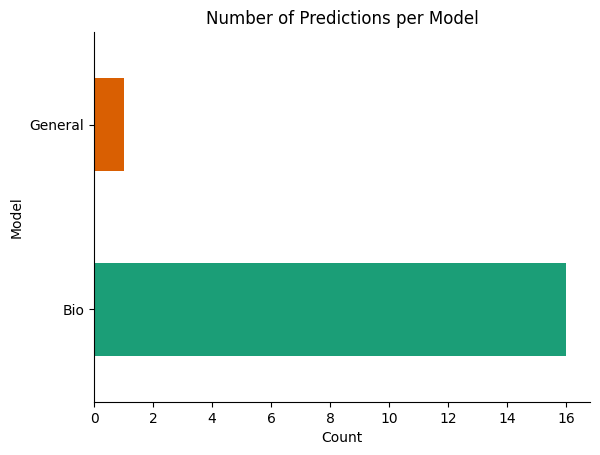

model
Bio        16
General     1
dtype: int64


In [20]:
#Prediction Counts Comparison

from matplotlib import pyplot as plt
import seaborn as sns

# Count predictions per model from the raw dataframe
counts = df.groupby("model").size()

# Plot
counts.plot(kind="barh", color=sns.palettes.mpl_palette("Dark2"))
plt.title("Number of Predictions per Model")
plt.xlabel("Count")
plt.ylabel("Model")
plt.gca().spines[['top','right']].set_visible(False)
plt.show()

print(counts)


In [16]:
#Entity coverage
df.groupby(["model","entity"]).size()


model    entity              
Bio      Biological_structure    1
         Disease_disorder        3
         Dosage                  1
         History                 1
         Medication              9
         Sign_symptom            1
General  MISC                    1
dtype: int64

In [17]:
#Confidence level score comparison
df.groupby("model")["score"].mean()


,score
model,
Bio,0.958017
General,0.770056
